In [1]:
import numpy as np # linear algebra
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flipkart-fashion-products-dataset-json/flipkart_fashion_products_dataset.json


In [3]:
from datasets import load_dataset
full_dataset = load_dataset("json", data_files='/kaggle/input/flipkart-fashion-products-dataset-json/flipkart_fashion_products_dataset.json')
cols_to_remove = list(full_dataset['train'].features.keys())
print(cols_to_remove)
cols_to_remove.remove('description')
cols_to_remove.remove('title')
cols_to_remove.remove('pid')
dataset=full_dataset
dataset = dataset.remove_columns(cols_to_remove)
dataset

['url', 'seller', 'out_of_stock', 'sub_category', 'average_rating', 'title', 'discount', '_id', 'images', 'brand', 'category', 'actual_price', 'product_details', 'crawled_at', 'selling_price', 'description', 'pid']


DatasetDict({
    train: Dataset({
        features: ['title', 'description', 'pid'],
        num_rows: 30000
    })
})

In [4]:
# Split the dataset
dataset = dataset['train'].train_test_split(test_size=0.1)

test_val = dataset['test'].train_test_split(test_size=0.5)
dataset['val'] = test_val['train']
dataset['test'] = test_val['test']

dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'description', 'pid'],
        num_rows: 27000
    })
    test: Dataset({
        features: ['title', 'description', 'pid'],
        num_rows: 1500
    })
    val: Dataset({
        features: ['title', 'description', 'pid'],
        num_rows: 1500
    })
})

In [5]:
dataset.save_to_disk('ecommerce_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/27000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

In [6]:
!pip install accelerate==0.20.3
!pip install transformers==4.33.1

  Using cached accelerate-0.20.3-py3-none-any.whl.metadata (17 kB)
Using cached accelerate-0.20.3-py3-none-any.whl (227 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.15.0
    Uninstalling accelerate-0.15.0:
      Successfully uninstalled accelerate-0.15.0


In [7]:
!pip install nltk==3.5
import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
import wandb
from datasets import load_from_disk, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, \
                         DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

2024-05-14 00:47:04.106701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 00:47:04.106765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 00:47:04.108374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
!pip install rouge_score
!pip install rouge

In [9]:
!pip install jiwer

In [10]:
# !pip install -U nltk

In [11]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge import Rouge
import jiwer
from nltk.translate.meteor_score import meteor_score

In [12]:
nltk.download('punkt')
# Initialize T5-base tokenizer
tokenizer = AutoTokenizer.from_pretrained('t5-base')
dataset = load_from_disk('ecommerce_dataset')
MAX_SOURCE_LEN = 256
MAX_TARGET_LEN = 64

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [13]:
# def preprocess_data(example):
    
#     model_inputs = tokenizer(example['description'], max_length=MAX_SOURCE_LEN, padding=True, truncation=True)

#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer(example['title'], max_length=MAX_TARGET_LEN, padding=True, truncation=True)

#     # Replace all pad token ids in the labels by -100 to ignore padding in the loss
#     labels["input_ids"] = [
#         [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
#     ]

#     model_inputs['labels'] = labels["input_ids"]

#     return model_inputs

# def compute_metrics(pred):
#     labels_ids = pred.label_ids
#     pred_ids = pred.predictions

#     # Decode the token ids to text
#     pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     labels_ids[labels_ids == -100] = tokenizer.pad_token_id
#     label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

#     # Calculate BLEU Score
#     smoothie = SmoothingFunction().method4
#     bleu = corpus_bleu([[ref] for ref in label_str], pred_str, smoothing_function=smoothie)

#     # Calculate ROUGE
#     rouge = Rouge()
#     scores = rouge.get_scores(pred_str, label_str, avg=True)

#     # Calculate Word Error Rate
#     wer = jiwer.wer(label_str, pred_str)

#     # Calculate METEOR Score
#     meteor = np.mean([meteor_score([ref], pred) for ref, pred in zip(label_str, pred_str)])

#     return {
#         'bleu': bleu,
#         'rouge': scores,
#         'wer': wer,
#         'meteor': meteor
#     }

In [14]:
def preprocess_data(example):
    
    model_inputs = tokenizer(example['description'], max_length=MAX_SOURCE_LEN, padding=True, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example['title'], max_length=MAX_TARGET_LEN, padding=True, truncation=True)

    # Replace all pad token ids in the labels by -100 to ignore padding in the loss
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]

    model_inputs['labels'] = labels["input_ids"]

    return model_inputs

In [15]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the token ids to text
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Calculate BLEU Score
    smoothie = SmoothingFunction().method4
    bleu = corpus_bleu([[ref] for ref in label_str], pred_str, smoothing_function=smoothie)

    # Calculate ROUGE
    rouge = Rouge()
    scores = rouge.get_scores(pred_str, label_str, avg=True)

    # Calculate Word Error Rate
    wer = jiwer.wer(label_str, pred_str)

    # Calculate METEOR Score
    meteor = np.mean([meteor_score([ref], pred) for ref, pred in zip(label_str, pred_str)])

    # Store the metrics for plotting
    metrics_history['epoch'].append(epoch_tracker['epoch'])
    metrics_history['bleu'].append(bleu)
    metrics_history['wer'].append(wer)
    metrics_history['meteor'].append(meteor)
    metrics_history['rouge-1-p'].append(scores['rouge-1']['p'])
    metrics_history['rouge-1-r'].append(scores['rouge-1']['r'])
    metrics_history['rouge-1-f'].append(scores['rouge-1']['f'])
    metrics_history['rouge-2-p'].append(scores['rouge-2']['p'])
    metrics_history['rouge-2-r'].append(scores['rouge-2']['r'])
    metrics_history['rouge-2-f'].append(scores['rouge-2']['f'])
    metrics_history['rouge-l-p'].append(scores['rouge-l']['p'])
    metrics_history['rouge-l-r'].append(scores['rouge-l']['r'])
    metrics_history['rouge-l-f'].append(scores['rouge-l']['f'])

    return {
        'bleu': bleu,
        'rouge': scores,
        'wer': wer,
        'meteor': meteor
    }

In [16]:
# # Apply preprocess_data() to the whole dataset
# processed_dataset = dataset.map(
#     preprocess_data,
#     batched=True,
#     remove_columns=['description', 'title'],
#     desc="Running tokenizer on dataset",
# )

# processed_dataset
# batch_size = 8
# num_epochs = 10
# learning_rate = 5.6e-5
# weight_decay = 0.01

# eval_every = 1000
# lr_scheduler_type = "linear"
# # Define training arguments
# training_args = Seq2SeqTrainingArguments(
#     output_dir="model-t5-base",
#     evaluation_strategy="steps",
#     eval_steps=eval_every,
#     learning_rate=learning_rate,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     weight_decay=weight_decay,
#     save_steps=500,
#     save_total_limit=3,
#     num_train_epochs=num_epochs,
#     predict_with_generate=True,
    
#     group_by_length=True,
#     lr_scheduler_type=lr_scheduler_type,
#     resume_from_checkpoint=True,
# )

In [17]:
!pip uninstall -y accelerate
!pip install accelerate>=0.20.1
!pip uninstall transformers 
!pip install transformers==4.33.1

Found existing installation: accelerate 0.20.3
Uninstalling accelerate-0.20.3:
  Successfully uninstalled accelerate-0.20.3
ERROR: unknown command "uuninstall" - maybe you meant "uninstall"


In [18]:
# Apply preprocess_data() to the whole dataset
processed_dataset = dataset.map(
    preprocess_data,
    batched=True,
    remove_columns=['description', 'title'],
    desc="Running tokenizer on dataset",
)

processed_dataset
batch_size = 8
num_epochs = 10
learning_rate = 5.6e-5
weight_decay = 0.01

eval_every = 1000
lr_scheduler_type = "linear"

# Track metrics and epochs
metrics_history = {
    'epoch': [],
    'bleu': [],
    'wer': [],
    'meteor': [],
    'rouge-1-p': [],
    'rouge-1-r': [],
    'rouge-1-f': [],
    'rouge-2-p': [],
    'rouge-2-r': [],
    'rouge-2-f': [],
    'rouge-l-p': [],
    'rouge-l-r': [],
    'rouge-l-f': []
}
epoch_tracker = {'epoch': 0}

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="model-t5-base",
    evaluation_strategy="steps",
    eval_steps=eval_every,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=weight_decay,
    save_steps=500,
    save_total_limit=3,
    num_train_epochs=num_epochs,
    predict_with_generate=True,
    logging_steps=eval_every,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

Running tokenizer on dataset:   0%|          | 0/27000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Running tokenizer on dataset:   0%|          | 0/1500 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [19]:
# Initialize T5-base model
model = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
!pip install accelerate==0.15.0
!pip install transformers==4.33.1
trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Using cached accelerate-0.15.0-py3-none-any.whl.metadata (15 kB)
Using cached accelerate-0.15.0-py3-none-any.whl (191 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.30.1
    Uninstalling accelerate-0.30.1:
      Successfully uninstalled accelerate-0.30.1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
import transformers
# TRYING, REMOVE LATER IF NOT 
# Custom callback to update epoch tracker
class EpochTrackerCallback(transformers.TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_tracker['epoch'] += 1

trainer.add_callback(EpochTrackerCallback)

In [21]:
trainer.train()

wandb: Currently logged in as: vansh3083 (gen-ai-project). Use `wandb login --relogin` to force relogin


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Bleu,Rouge,Wer,Meteor
1000,1.396400,0.788311,0.594829,"{'rouge-1': {'r': 0.5761692318574664, 'p': 0.5962261423761421, 'f': 0.5797708157968973}, 'rouge-2': {'r': 0.36755766104266174, 'p': 0.38308246753246766, 'f': 0.370706598669404}, 'rouge-l': {'r': 0.5711522765905108, 'p': 0.5907433381433375, 'f': 0.5745937400690473}}",0.511969,0.512771
2000,0.819600,0.655986,0.632855,"{'rouge-1': {'r': 0.6158560382972127, 'p': 0.6357266714766698, 'f': 0.6203216926031739}, 'rouge-2': {'r': 0.4386987505087509, 'p': 0.45378518518518546, 'f': 0.4424282152294232}, 'rouge-l': {'r': 0.6119838160749901, 'p': 0.631329846079844, 'f': 0.6162282836156472}}",0.462650,0.574439
3000,0.705100,0.592394,0.596659,"{'rouge-1': {'r': 0.5870165382547726, 'p': 0.5993202260702255, 'f': 0.5885798312497889}, 'rouge-2': {'r': 0.4063156841306849, 'p': 0.4182742905242914, 'f': 0.4093534178352846}, 'rouge-l': {'r': 0.5661410452292801, 'p': 0.5794448292448267, 'f': 0.568438831182317}}",0.523112,0.531728
4000,0.640300,0.556848,0.646031,"{'rouge-1': {'r': 0.6285455344220036, 'p': 0.6429491582491574, 'f': 0.6312569898879684}, 'rouge-2': {'r': 0.4405672016872023, 'p': 0.4483566859066867, 'f': 0.44165285056634906}, 'rouge-l': {'r': 0.6247278095542784, 'p': 0.6384983645983633, 'f': 0.6271727384095992}}",0.445625,0.572972
5000,0.601600,0.530843,0.681661,"{'rouge-1': {'r': 0.6482048021695079, 'p': 0.6609815795315782, 'f': 0.6505163875606899}, 'rouge-2': {'r': 0.48195757002257117, 'p': 0.49336019721019797, 'f': 0.48492966895741185}, 'rouge-l': {'r': 0.6447616804763859, 'p': 0.6573519499019482, 'f': 0.6470163265106289}}",0.425506,0.609734
6000,0.568100,0.522492,0.671274,"{'rouge-1': {'r': 0.6481229815935688, 'p': 0.6624651755651743, 'f': 0.6506521886366818}, 'rouge-2': {'r': 0.48385777167277166, 'p': 0.4941813852813855, 'f': 0.48597469763720225}, 'rouge-l': {'r': 0.644569806990394, 'p': 0.6583699374699357, 'f': 0.646868303458679}}",0.424474,0.610696
7000,0.552500,0.511767,0.678476,"{'rouge-1': {'r': 0.6522724955871998, 'p': 0.6667842601842587, 'f': 0.6551069177227462}, 'rouge-2': {'r': 0.49100397694897707, 'p': 0.5020655363155364, 'f': 0.493536330207713}, 'rouge-l': {'r': 0.648993395058099, 'p': 0.6629552003551986, 'f': 0.6515888713246997}}",0.420243,0.614708
8000,0.535700,0.499543,0.664022,"{'rouge-1': {'r': 0.6444708237296459, 'p': 0.6573462722462714, 'f': 0.6468867281068598}, 'rouge-2': {'r': 0.46162249269249356, 'p': 0.4703220779220788, 'f': 0.4634042299111571}, 'rouge-l': {'r': 0.6409933105021327, 'p': 0.6532907166907155, 'f': 0.6431570577771893}}",0.423545,0.588637
9000,0.523000,0.493481,0.683573,"{'rouge-1': {'r': 0.6576778389366607, 'p': 0.6706330299330281, 'f': 0.6599171542719219}, 'rouge-2': {'r': 0.4982071980837198, 'p': 0.5087557720057724, 'f': 0.50053878240405}, 'rouge-l': {'r': 0.65439873840756, 'p': 0.6668198431198409, 'f': 0.6564064338812013}}",0.415085,0.620809
10000,0.513200,0.488707,0.668383,"{'rouge-1': {'r': 0.6503691494779719, 'p': 0.6623915972915969, 'f': 0.6522104039472479}, 'rouge-2': {'r': 0.4705900805796469, 'p': 0.4775574074074083, 'f': 0.4714951389127302}, 'rouge-l': {'r': 0.6468916362504585, 'p': 0.6583360417360409, 'f': 0.6484807336175775}}",0.420243,0.595150


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "{'rouge-1': {'r': 0.5761692318574664, 'p': 0.5962261423761421, 'f': 0.5797708157968973}, 'rouge-2': {'r': 0.36755766104266174, 'p': 0.38308246753246766, 'f': 0.370706598669404}, 'rouge-l': {'r': 0.5711522765905108, 'p': 0.5907433381433375, 'f': 0.5745937400690473}}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, b

TrainOutput(global_step=16880, training_loss=0.6033683849172005, metrics={'train_runtime': 14877.697, 'train_samples_per_second': 18.148, 'train_steps_per_second': 1.135, 'total_flos': 8.22093152256e+16, 'train_loss': 0.6033683849172005, 'epoch': 10.0})

In [22]:
eval_results = trainer.evaluate(eval_dataset=processed_dataset['test'])

Trainer is attempting to log a value of "{'rouge-1': {'r': 0.6471064918977958, 'p': 0.6545769119769099, 'f': 0.6467205889001476}, 'rouge-2': {'r': 0.4901449716949723, 'p': 0.49718095238095283, 'f': 0.49036399795395125}, 'rouge-l': {'r': 0.6449628577541614, 'p': 0.6520991341991318, 'f': 0.6444369747365337}}" of type <class 'dict'> for key "eval/rouge" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [23]:
# # Extract metrics for plotting
# bleu_score = eval_results['eval_bleu']
# rouge_scores = eval_results['eval_rouge']
# wer_score = eval_results['eval_wer']
# meteor_score_val = eval_results['eval_meteor']

In [24]:
!pip install matplotlib
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


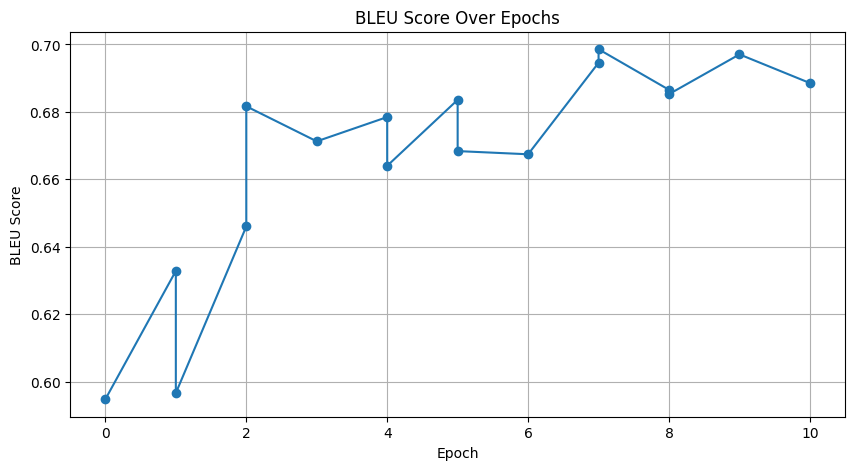

In [25]:
# Plot BLEU Score over epochs
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['epoch'], metrics_history['bleu'], marker='o')
plt.title('BLEU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()

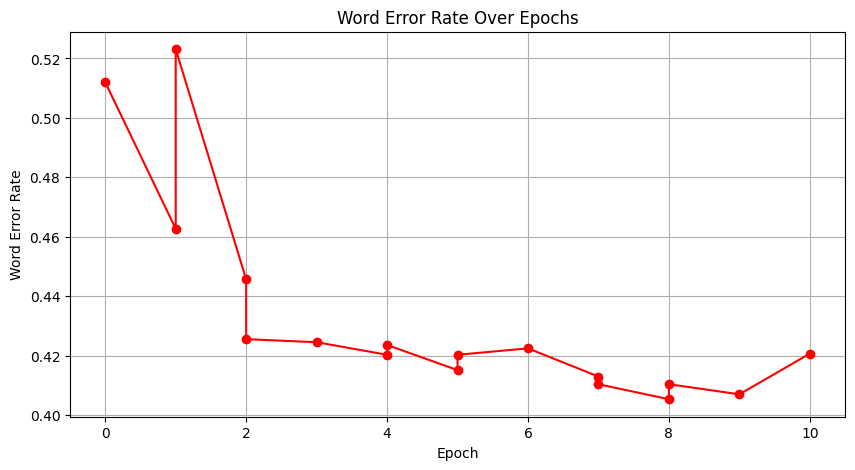

In [26]:
# Plot Word Error Rate over epochs
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['epoch'], metrics_history['wer'], marker='o', color='red')
plt.title('Word Error Rate Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Word Error Rate')
plt.grid(True)
plt.show()

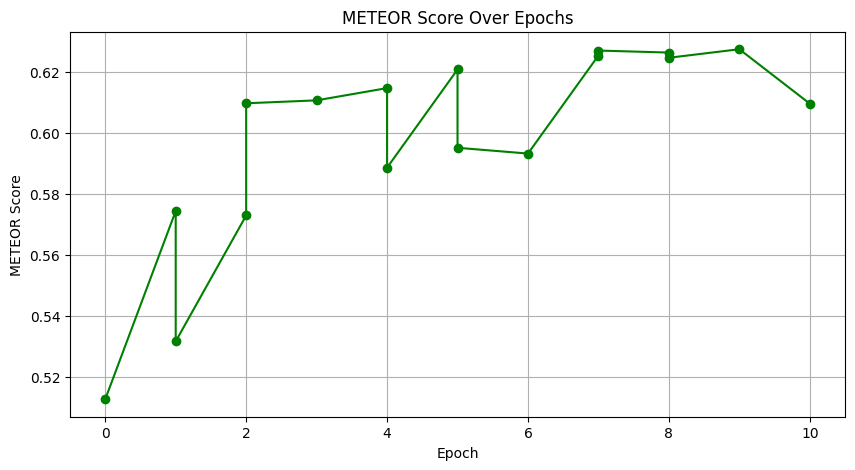

In [27]:
# Plot METEOR Score over epochs
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['epoch'], metrics_history['meteor'], marker='o', color='green')
plt.title('METEOR Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('METEOR Score')
plt.grid(True)
plt.show()

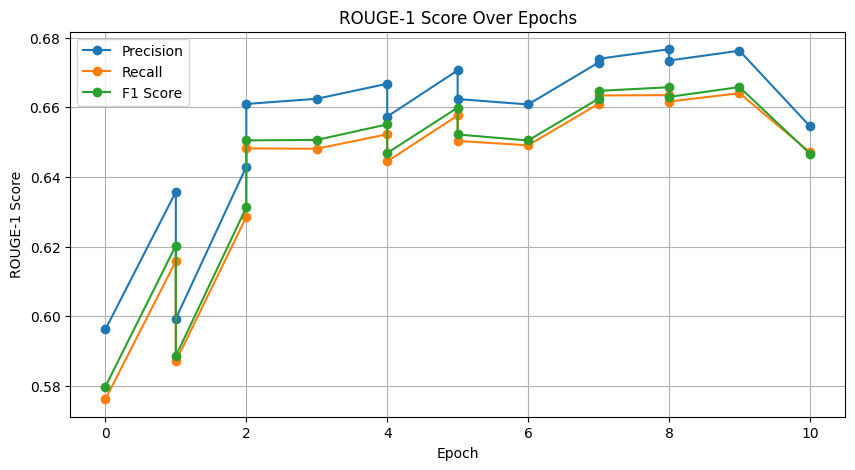

In [28]:
# Plot ROUGE-1 Score over epochs
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['epoch'], metrics_history['rouge-1-p'], marker='o', label='Precision')
plt.plot(metrics_history['epoch'], metrics_history['rouge-1-r'], marker='o', label='Recall')
plt.plot(metrics_history['epoch'], metrics_history['rouge-1-f'], marker='o', label='F1 Score')
plt.title('ROUGE-1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('ROUGE-1 Score')
plt.legend()
plt.grid(True)
plt.show()

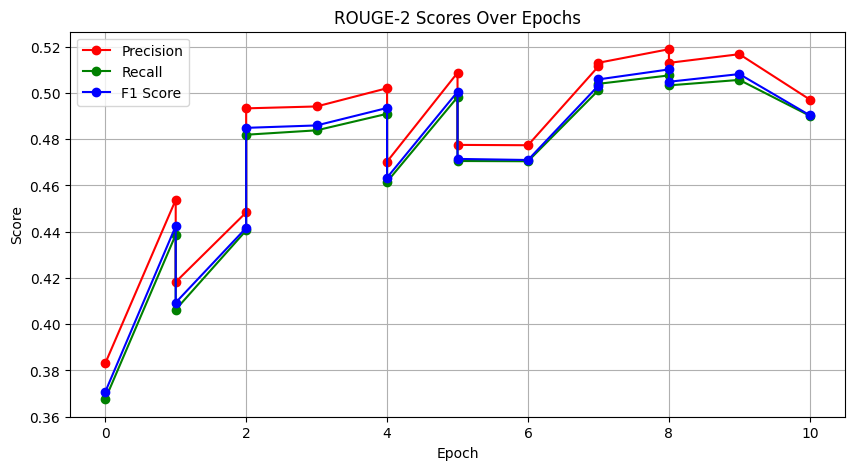

In [29]:
# Plot ROUGE-2 Scores over epochs
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['epoch'], metrics_history['rouge-2-p'], marker='o', label='Precision', color='r')
plt.plot(metrics_history['epoch'], metrics_history['rouge-2-r'], marker='o', label='Recall', color='g')
plt.plot(metrics_history['epoch'], metrics_history['rouge-2-f'], marker='o', label='F1 Score', color='b')
plt.title('ROUGE-2 Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

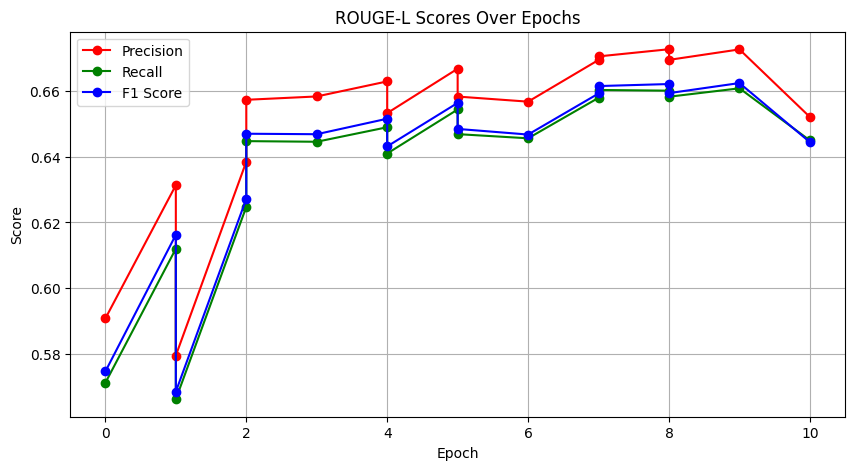

In [30]:
# Plot ROUGE-L Scores over epochs
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['epoch'], metrics_history['rouge-l-p'], marker='o', label='Precision', color='r')
plt.plot(metrics_history['epoch'], metrics_history['rouge-l-r'], marker='o', label='Recall', color='g')
plt.plot(metrics_history['epoch'], metrics_history['rouge-l-f'], marker='o', label='F1 Score', color='b')
plt.title('ROUGE-L Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

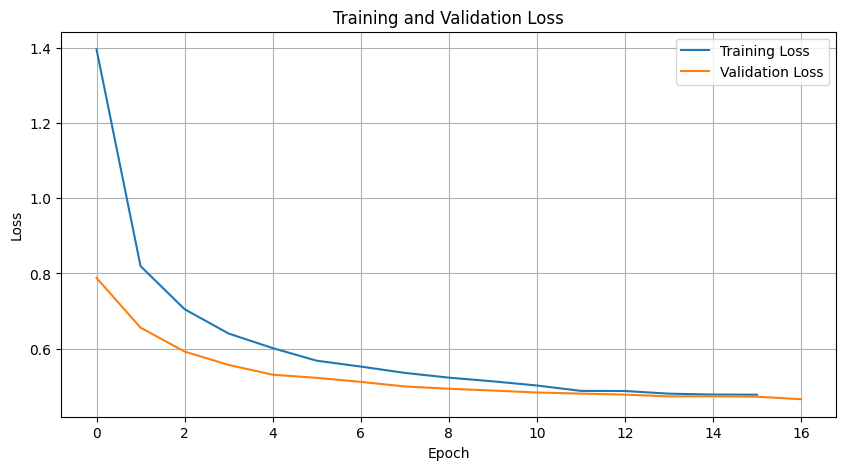

In [31]:
# Plot the training and validation loss
train_logs = trainer.state.log_history

# Extract train and validation loss
train_loss = [log['loss'] for log in train_logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
temperature = 0.9
num_beams = 4
max_gen_length = 128

In [33]:
# abstract = dataset['test'][0]['abstract']
description = "Open your door to the world of grilling with the sleek Spirit II E-210 gas grill. This two burner grill is built to fit small spaces, and packed with features such as the powerful GS4 grilling system, iGrill capability, and convenient side tables for placing serving trays. Welcome to the Weber family."
inputs = tokenizer([description], max_length=256, return_tensors='pt')

title_ids = model.generate(
    inputs['input_ids'].to('cuda'), 
    num_beams=num_beams, 
    temperature=temperature, 
    max_length=max_gen_length, 
    early_stopping=True
)
title = tokenizer.decode(title_ids[0].tolist(), skip_special_tokens=True, clean_up_tokenization_spaces=False)
print(title)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Spirit II Solid Men Grill (Pack of 2)


In [34]:
# Define a directory to save the model
output_dir = "./saved_model"

# Save the model
trainer.save_model(output_dir)
!zip -r output.zip /kaggle/working/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/=0.20.1 (deflated 81%)
  adding: kaggle/working/wandb/ (stored 0%)
  adding: kaggle/working/wandb/debug.log (deflated 75%)
  adding: kaggle/working/wandb/run-20240514_003701-slbzjw9a/ (stored 0%)
  adding: kaggle/working/wandb/run-20240514_003701-slbzjw9a/run-slbzjw9a.wandb (deflated 73%)
  adding: kaggle/working/wandb/run-20240514_003701-slbzjw9a/files/ (stored 0%)
  adding: kaggle/working/wandb/run-20240514_003701-slbzjw9a/files/requirements.txt (deflated 58%)
  adding: kaggle/working/wandb/run-20240514_003701-slbzjw9a/files/conda-environment.yaml (stored 0%)
  adding: kaggle/working/wandb/run-20240514_0

In [37]:
metrics_df = pd.DataFrame(metrics_history)

In [38]:
metrics_df

,epoch,bleu,wer,meteor,rouge-1-p,rouge-1-r,rouge-1-f,rouge-2-p,rouge-2-r,rouge-2-f,rouge-l-p,rouge-l-r,rouge-l-f
0,0,0.594829,0.511969,0.512771,0.596226,0.576169,0.579771,0.383082,0.367558,0.370707,0.590743,0.571152,0.574594
1,1,0.632855,0.462650,0.574439,0.635727,0.615856,0.620322,0.453785,0.438699,0.442428,0.631330,0.611984,0.616228
2,1,0.596659,0.523112,0.531728,0.599320,0.587017,0.588580,0.418274,0.406316,0.409353,0.579445,0.566141,0.568439
3,2,0.646031,0.445625,0.572972,0.642949,0.628546,0.631257,0.448357,0.440567,0.441653,0.638498,0.624728,0.627173
4,2,0.681661,0.425506,0.609734,0.660982,0.648205,0.650516,0.493360,0.481958,0.484930,0.657352,0.644762,0.647016
5,3,0.671274,0.424474,0.610696,0.662465,0.648123,0.650652,0.494181,0.483858,0.485975,0.658370,0.644570,0.646868
6,4,0.678476,0.420243,0.614708,0.666784,0.652272,0.655107,0.502066,0.491004,0.493536,0.662955,0.648993,0.651589
7,4,0.664022,0.423545,0.588637,0.657346,0.644471,0.646887,0.470322,0.461622,0.463404,0.653291,0.640993,0.643157
8,5,0.683573,0.415085,0.620809,0.670633,0.657678,0.659917,0.508756,0.498207,0.500539,0.666820,0.654399,0.656406
9,5,0.668383,0.420243,0.595150,0.662392,0.650369,0.652210,0.477557,0.470590,0.471495,0.658336,0.646892,0.648481


In [35]:
# kaggle datasets download -d vanshsaini308/dataset-name -p /path/to/save

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ kaggle datasets download -d vanshsaini3083/dataset-name -p /path/to/save                         │
│        ▲                                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax